# Cross-val predict on seen data

# Prediction on unseen data

In [1]:
# Create empty target raster from shape with NaN outside of shape
from ltm.data import shapefile2raster
from pathlib import Path

shapefile_path = "../data/raw/Freisinger Forst/Freisinger Forst.shp"
target_path = f"../data/processed/generalization/Freisinger Forst.tif"
Path(target_path).parent.mkdir(parents=True, exist_ok=True)

if not Path(target_path).exists():
    shapefile2raster(
        target_path,
        shapefile_path,
    )

In [2]:
# Get optimal composite values
import pandas as pd

df = pd.read_csv("../reports/reducer_composites.csv")
metric = "Root Mean Squared Error"

optimal_idx = df.groupby("Reducer")[metric].idxmin()
optimal_df = df.loc[optimal_idx]
optimal_df = optimal_df.set_index("Reducer")

reducers = [
    "median",
    "mean",
    "mode",
    "min",
    "max",
    "sampleVariance",
    "kendallsCorrelation",
    "skew",
    "kurtosis",
]

optimal_df = optimal_df.loc[reducers]
composite_dict = optimal_df["Composites"].to_dict()

composite_dict

{'median': 10,
 'mean': 11,
 'mode': 12,
 'min': 12,
 'max': 12,
 'sampleVariance': 2,
 'kendallsCorrelation': 3,
 'skew': 1,
 'kurtosis': 5}

In [3]:
# List the optimal bands
from ltm.models import bands_from_importance

sentinel_bands, indices = bands_from_importance(
    "../reports/band_importance.csv"
)

sentinel_bands, indices

Initializing Earth Engine API...


(['B9', 'WVP', 'TCI_G'],
 ['BAIM',
  'BCC',
  'BRBA',
  'BWDRVI',
  'GCC',
  'GVMI',
  'MCARI705',
  'MGRVI',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'NBRplus',
  'NDCI',
  'NDDI',
  'NDGI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'VIBI',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'kVARI',
  'mND705',
  'mSR705'])

In [4]:
# Create composite
from ltm.data import sentinel_composite
from ltm.features import load_raster, interpolate_data, to_float32, save_raster
from datetime import datetime
from tqdm import tqdm

# Define start year, starting at July 1st until June 30th of the next year
YEAR = 2020

# Create the composite folder
stem = Path(target_path).stem
composite_folder = Path(target_path).parent / stem
composite_folder.mkdir(exist_ok=True)

# Handle each reducer separately
total_data = pd.DataFrame()
for reducer, num_composites in tqdm(composite_dict.items()):
    composite_path = f"{composite_folder}/{stem}_{reducer}_{num_composites}.tif"  # Create the composite if it does not exist
    if not Path(composite_path).exists():
        sentinel_composite(
            target_path,
            composite_path,
            time_window=(datetime(YEAR, 7, 1), datetime(YEAR + 1, 7, 1)),
            num_composites=num_composites,
            temporal_reducers=[reducer],
            indices=indices,
            sentinel_bands=sentinel_bands,
        )

    # Combine into one raster
    data = load_raster(composite_path)
    data = interpolate_data(data)
    data.dropna(axis=1, inplace=True)  # Kendall's Correlation P-Value
    data = to_float32(data)
    total_data = pd.concat([total_data, data], axis=1)

# Save the total data
total_data_path = f"{composite_folder}/{stem}.tif"
if not Path(total_data_path).exists():
    save_raster(total_data, target_path, total_data_path)

# Load the data
data = load_raster(total_data_path)

100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


In [5]:
# Train best model on labeled data of the study area
import dill
from ltm.features import drop_nan_rows

df = pd.read_csv("../reports/hyperparameter_tuning.csv", index_col=0)
best_model = df["Root Mean Squared Error"].idxmin()

with open(f"../models/{best_model}.pkl", "rb") as f:
    model = dill.load(f)

# Load the data
study_area_data = load_raster("../data/processed/data.tif")
study_area_target = load_raster("../data/processed/target.tif")
study_area_data, study_area_target = drop_nan_rows(study_area_data, study_area_target)

# Train the model
model.fit(study_area_data, study_area_target)

model

c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.34432013037059533,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.055442782481545896, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=8, missing=nan,
                              monotone_constraints=None, n_estimators=83,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=42, ...))])

In [6]:
# Save prediction to target raster
xgb_pred = model.predict(data)

xgb_pred

c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

array([0.83891183, 0.8189969 , 0.9247274 , 0.90097225, 0.88734573,
       0.8819417 , 0.8091682 , 0.8388711 , 0.9392891 , 0.8917393 ,
       0.83698267, 0.81716466, 0.8298583 , 0.8288125 , 0.82122713,
       0.88489634, 0.8606899 , 0.8377571 , 0.79047734, 0.82821757,
       0.87932664, 0.889264  , 0.8788731 , 0.8034258 , 0.81079304,
       0.8258423 , 0.8768998 , 0.839205  , 0.8052932 , 0.8270409 ,
       0.8918224 , 0.92996216, 0.78095365, 0.7990397 , 0.74397385,
       0.78235054, 0.86992097, 0.86772346, 0.9327162 , 0.7723335 ,
       0.81765926, 0.8254658 , 0.82768816, 0.8296909 , 0.8078812 ,
       0.79958004, 0.9192076 , 0.9347772 , 0.85282415, 0.78170395,
       0.79010975, 0.87286645, 0.93365765, 0.9360779 , 0.93618006,
       0.9022077 , 0.89929765, 0.8803861 , 0.8867598 , 0.8579514 ,
       0.8065682 , 0.89263934, 0.87303567, 0.86415696, 0.92249656,
       0.88544035, 0.9203119 , 0.959648  , 0.9275763 , 0.9395418 ,
       0.9439564 , 0.90007395, 0.91642755, 0.7968512 , 0.83036

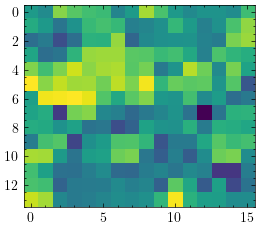

In [10]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open(target_path) as src:
    shape = src.read().shape

xgb_reshaped = xgb_pred.reshape(shape)

plt.imshow(xgb_reshaped.transpose(1, 2, 0), cmap="viridis")

In [7]:
# Plot the prediction
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")